<a href="https://colab.research.google.com/github/chayakim/Data_Analytics/blob/main/Final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

energy_df['time'] = pd.to_datetime(energy_df['time'], errors='coerce', utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], errors='coerce', utc=True)

energy_df['time'] = energy_df['time'].dt.tz_localize(None)
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_localize(None)

merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso', how='inner')

merged_df.drop(columns=['dt_iso', 'city_name'], inplace=True)

merged_df.fillna(method='ffill', inplace=True)

merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month

weather_features = merged_df[['temp', 'wind_speed', 'humidity', 'pressure','rain_1h']]
scaler = StandardScaler()
weather_features_scaled = scaler.fit_transform(weather_features)

kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['weather_cluster'] = kmeans.fit_predict(weather_features_scaled)

lstm_features = ['temp', 'wind_speed','rain_1h','humidity', 'pressure', 'hour', 'day_of_week', 'month', 'weather_cluster', 'total load actual']
lstm_data = merged_df[lstm_features]

scaler_lstm = StandardScaler()
lstm_data_scaled = scaler_lstm.fit_transform(lstm_data)

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :-1])
        labels.append(data[i + seq_length, -1])
    return np.array(sequences), np.array(labels)

sequence_length = 24
X, y = create_sequences(lstm_data_scaled, sequence_length)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)

target_mean = scaler_lstm.mean_[-1]
target_scale = scaler_lstm.scale_[-1]

y_test_rescaled = (y_test * target_scale) + target_mean
y_pred_rescaled = (y_pred * target_scale) + target_mean

print("Test Loss:", test_loss)
print("First 5 Actuals:", y_test_rescaled[:5])
print("First 5 Predictions:", y_pred_rescaled[:5])

<ipython-input-8-18b55c2a457d>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.4316 - val_loss: 0.3728
Epoch 2/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.3400 - val_loss: 0.3718
Epoch 3/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.3044 - val_loss: 0.3870
Epoch 4/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.2735 - val_loss: 0.4135
Epoch 5/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.2413 - val_loss: 0.4352
Epoch 6/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.2100 - val_loss: 0.4122
Epoch 7/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.1877 - val_loss: 0.4706
Epoch 8/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.1643 - val_loss: 0.4400
Epoch 9/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.1468 - val_loss: 0.4477
Epoch 10/10
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.1326 - val_loss: 0.4692
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4381
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Los

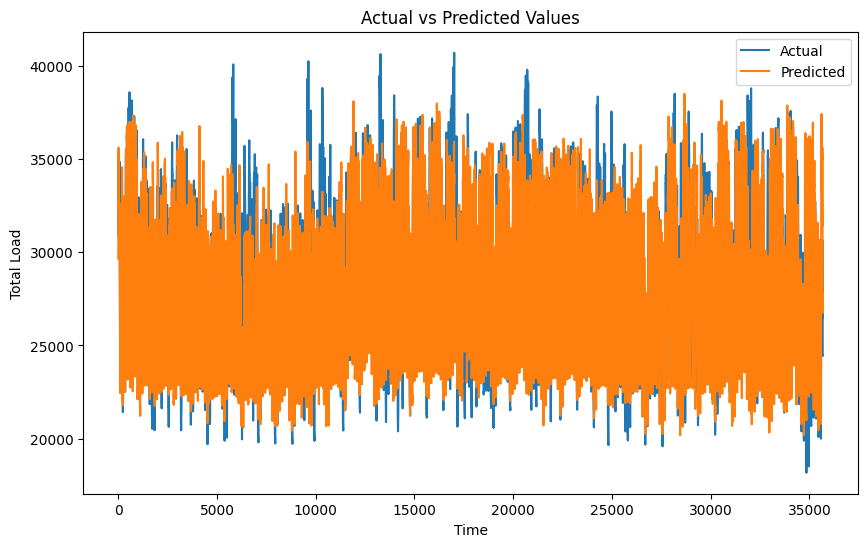

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred):
    """
    Plots the actual vs predicted values.

    Args:
        y_true: The actual values.
        y_pred: The predicted values.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Load')
    plt.legend()
    plt.show()

plot_actual_vs_predicted(y_test_rescaled, y_pred_rescaled)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Evaluation metrics
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Print the metrics
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

evaluate_model(y_test_rescaled, y_pred_rescaled)

R² Score: 0.5192
Mean Squared Error (MSE): 9841435.3410
Root Mean Squared Error (RMSE): 3137.1062
Mean Absolute Error (MAE): 2235.9701
Mean Absolute Percentage Error (MAPE): 17.6157%


In [ ]:
def forecast_future(model, last_sequence, n_days, target_mean, target_scale):
    """
    Forecast the next n_days using the trained LSTM model.

    Args:
    model: Trained LSTM model.
    last_sequence: The last sequence of features (from recent data) to predict future values.
    n_days: Number of future days to forecast.
    target_mean: Mean of the target variable from the scaler.
    target_scale: Scale of the target variable from the scaler.

    Returns:
    future_predictions_rescaled: Forecasted energy consumption values for the next n_days, rescaled to the original units.
    """
    future_predictions = []
    current_input = last_sequence.copy()

    current_input = current_input[np.newaxis, :, :]

    for _ in range(n_days):
        prediction = model.predict(current_input)[0, 0]

        future_predictions.append(prediction)

        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, -1] = prediction

    future_predictions_rescaled = (np.array(future_predictions) * target_scale) + target_mean

    return future_predictions_rescaled.flatten()


In [ ]:
last_sequence = X_test[-1]

target_mean = scaler_lstm.mean_[-1]
target_scale = scaler_lstm.scale_[-1]

forecast_365_days = forecast_future(model, last_sequence, 365 , target_mean, target_scale)

print("365 day Forecast:", forecast_365_days)

forecast_df = pd.DataFrame(forecast_365_days, columns=['Forecast'])

forecast_df.to_csv('output.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

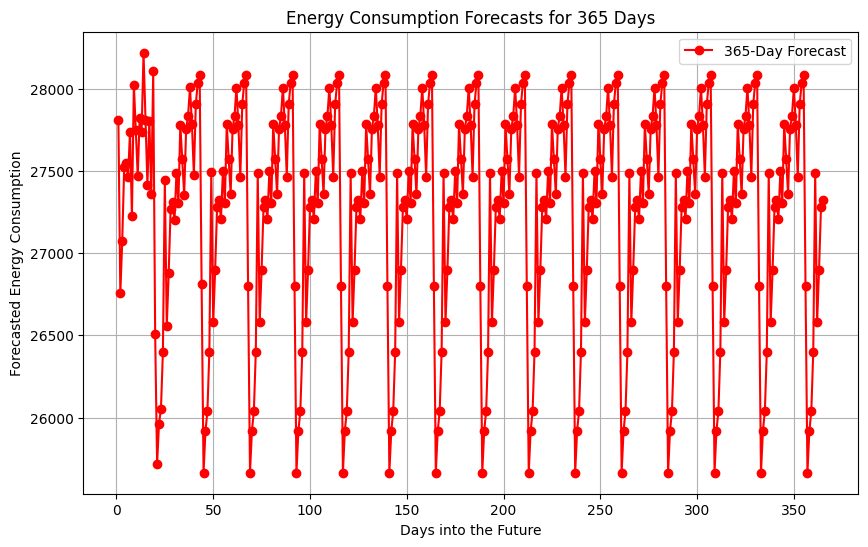

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts(forecast_365):
    plt.figure(figsize=(10, 6))

    plt.plot(np.arange(1, 366), forecast_365, label='365-Day Forecast', marker='o', color='red')

    plt.title('Energy Consumption Forecasts for 365 Days')
    plt.xlabel('Days into the Future')
    plt.ylabel('Forecasted Energy Consumption')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecasts(forecast_365_days)
